In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import spacy
import textacy
import wordcloud
import seaborn as sns

from functools import partial
from mpl_lego.labels import bold_text
from scipy.stats import bootstrap
from pyprojroot import here
from spacy_cleaner import processing, Cleaner
from textacy import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

from moral_foundations_llms import keys
 
%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
df = pd.read_csv(here('data/aita_final_v15.csv'))

/var/folders/6h/ms_dpkl536d1w6qqd_wnckrw0000gn/T/ipykernel_18729/2259072775.py:1: DtypeWarning: Columns (29,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(here('data/aita_final_v15.csv'))


In [5]:
preprocess = preprocessing.make_pipeline(
    preprocessing.normalize.quotation_marks,
    preprocessing.normalize.whitespace,
    preprocessing.remove.brackets,
    preprocessing.remove.punctuation)

In [6]:
docs = [[preprocess(x) for x in df[reason_col]]
        for reason_col in keys.REASON_COLS]

In [7]:
docs = [list(nlp.pipe(doc)) for doc in docs]

In [8]:
tokens = [[" ".join([token.lemma_ for token in current_doc 
                     if not token.is_stop
                     and not token.is_punct
                     and not token.like_num
                     and not token.is_currency
                     and not token in ['NTA', 'YTA', 'ESH', 'NAH', 'INF'] ])
           for current_doc in doc]
           for doc in docs]

In [9]:
tfidf_dfs = []

for token in tokens[1:]:
    vectorizer = TfidfVectorizer(max_features=3000, max_df=0.98, min_df=5)
    X = vectorizer.fit_transform(token)
    tfidf_dfs.append(
        pd.DataFrame(data=X.toarray(),
                     columns=vectorizer.get_feature_names_out()))

In [10]:
token_sets = []

for tfidf_df in tfidf_dfs:
    token_sets.append(set(tfidf_df.columns))

matching_tokens = set.intersection(*token_sets)

In [11]:
tfidf_dfs_matching = [tfidf_df.loc[:, tfidf_df.columns.isin(matching_tokens)]
                      for tfidf_df in tfidf_dfs]

In [12]:
corrs = np.zeros((7, 7))

for ii in range(7):
    for jj in range(7):
        corrs[ii, jj] = np.diag(cosine_similarity(tfidf_dfs_matching[ii], tfidf_dfs_matching[jj])).mean()

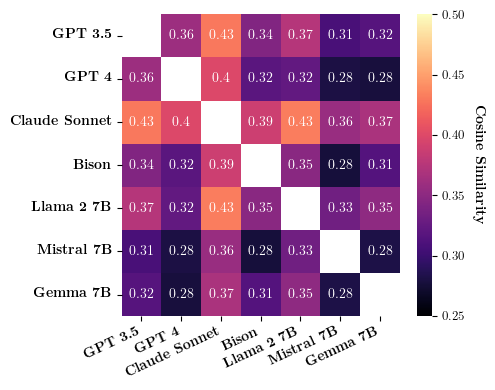

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.heatmap(corrs,
            annot=True,
            mask=np.identity(7),
            vmin=0.25,
            vmax=0.50,
            cmap='magma')
cbar = ax.collections[0].colorbar
cbar.set_label(bold_text("Cosine Similarity"), rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=9)

ax.set_xticklabels(bold_text(keys.MODEL_LABELS_PLOT[1:]), ha='right', rotation=25)
ax.set_yticklabels(bold_text(keys.MODEL_LABELS_PLOT[1:]), ha='right', rotation=0)
plt.tight_layout()
plt.savefig('word_similarity_tfidf.pdf', bbox_inches='tight')

In [14]:
dfs = []

for token in tokens:
    vectorizer = CountVectorizer(max_features=5000, max_df=0.98, min_df=5)
    X = vectorizer.fit_transform(token)
    dfs.append(
        pd.DataFrame(data=X.toarray(),
                     columns=vectorizer.get_feature_names_out()))

In [15]:
unique_columns = []

for ii, token_df in enumerate(dfs[1:]):
    # Get the column names of the current dataframe
    current_columns = set(token_df.columns)
    
    # Get the column names of all other dataframes
    other_columns = set()
    for jj, other_df in enumerate(dfs[1:]):
        if ii != jj:
            other_columns.update(other_df.columns)
    
    # Find unique columns by subtracting other dataframe columns from the current one
    unique_to_current = current_columns - other_columns
    unique_columns.append(unique_to_current)


In [30]:
dfs[1]['cement']

KeyError: 'cement'

In [29]:
unique_columns[1]

{'cement',
 'deflection',
 'deploy',
 'discord',
 'exempt',
 'guise',
 'immigration',
 'incapable',
 'indecisiveness',
 'joyful',
 'known',
 'mismatched',
 'obligatory',
 'overburden',
 'paramount',
 'pertain',
 'predict',
 'presumably',
 'rapid',
 'rating',
 'retract',
 'sanitary',
 'sharp',
 'supermarket',
 'wisely'}

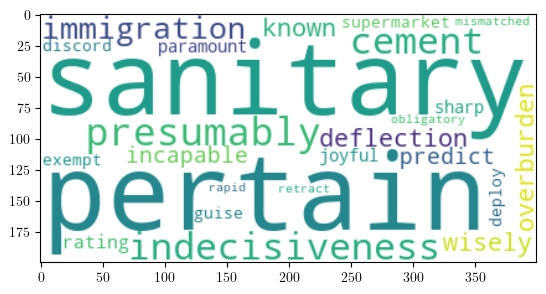

In [20]:
wc = wordcloud.WordCloud(background_color='white').generate(" ".join(list(unique_columns[1])))
plt.imshow(wc, interpolation='bilinear')

In [56]:
sums = [token_df.sum() for token_df in dfs[1:]]

In [61]:
all_tokens = sums[0].index
for series in sums[1:]:
    all_tokens = all_tokens.union(series.index)


In [63]:
new_sums = [series.reindex(all_tokens, fill_value=0) for series in sums]

In [71]:
len(keys.REASON_COLS)

8

In [74]:
final = pd.concat(new_sums, axis=1)
final.columns = keys.MODELS[1:]
final = final.T

In [78]:
stds = (final - final.mean(axis=0)) / final.std(axis=0)

In [87]:
stds['incarcerate']

gpt3.5    -0.377964
gpt4      -0.377964
claude     2.267787
bison     -0.377964
gemma     -0.377964
mistral   -0.377964
llama     -0.377964
Name: incarcerate, dtype: float64

In [94]:
final['hijack']

gpt3.5     0
gpt4       0
claude     6
bison      0
gemma      0
mistral    0
llama      0
Name: hijack, dtype: int64